# This is a notebook testing Noble.AI's implementation of a matrix product XY where Y is a SparseTensor.

### The work here suggests that one should use SparseTensor math because it's cheaper in time and memory depending on the density and size of the matrix.

### The command is `tf.transpose(tf.sparse.sparse_dense_matmul(Y, X, adjoint_a = True, adjoint_b = True))`


In [0]:
import numpy as np
import tensorflow as tf
import scipy
import os
import time
from matplotlib import pyplot as plt

tfk = tf.keras

### Make Testing Directory

In [0]:
this_dir = os.path.join(os.getcwd(),"eager-sparse-testing")
os.makedirs(this_dir,exist_ok=True)

# Say we want to compute the 2nd derivative of a signal

### We can do that by multiplying a matrix representing the 2nd derivative finite difference operator with a vector of the signal
#### Define the matrix on CPU RAM in dense format using NumPy 

In [0]:
matrix_size = 8192

dense_matrix = -2.*np.eye(matrix_size,k=0)
dense_matrix += np.eye(matrix_size,k=1)
dense_matrix += np.eye(matrix_size,k=-1)

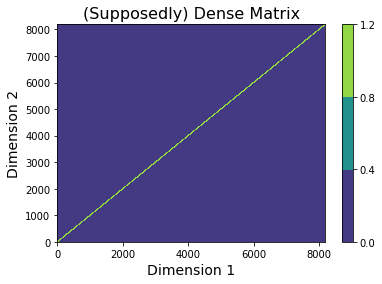

In [0]:
plt.contourf(np.abs(dense_matrix)>0,2)
plt.title("(Supposedly) Dense Matrix", fontsize = 16)
plt.xlabel("Dimension 1", fontsize = 14)
plt.ylabel("Dimension 2", fontsize = 14)
plt.colorbar()

### Generate a signal

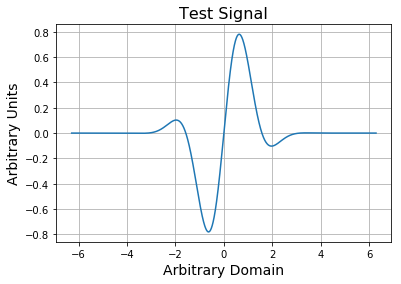

In [0]:
# Define a domain
xax = np.linspace(-2*np.pi,2*np.pi,matrix_size)

# This is a sinusoid damped at the edges by a Gaussian
data_vector = np.sin(2*xax)*np.exp(-0.5*xax**2.)

# Make the plot
plt.plot(xax,data_vector)
plt.title("Test Signal",fontsize=16)
plt.xlabel("Arbitrary Domain",fontsize=14)
plt.ylabel("Arbitrary Units",fontsize=14)
plt.grid()

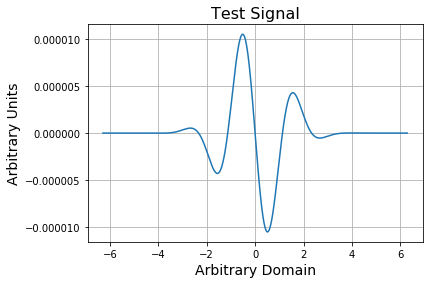

In [0]:
# Calculate 2nd Derivative
dense_out_np = np.dot(dense_matrix,data_vector)


# Make the plot
plt.plot(xax,dense_out_np)
plt.title("Test Signal",fontsize=16)
plt.xlabel("Arbitrary Domain",fontsize=14)
plt.ylabel("Arbitrary Units",fontsize=14)
plt.grid()

In [0]:
print ("The percentage of entries with a non-zero value: " + str(round(np.sum((np.abs(dense_matrix)>0).flatten())/(matrix_size**2)*100.,4)) + "%")

The percentage of entries with a non-zero value: 0.0366%


#### Not very dense, is it!

In [0]:
dense_matrix_filename = os.path.join(this_dir,"dense_matrix.npy")
np.save(dense_matrix_filename, dense_matrix)
print ("The dense matrix is " + str(os.stat(dense_matrix_filename).st_size/1e6) + " MB")

The dense matrix is 536.87104 MB


#### TF does not allow for tensors > 2 GB. This limit is easy to reach. Each float is 8 bytes. The above file was 8192x8192x8 bytes ~ 536.87 MB
#### If each dimension were 2x larger, we would reach the limit.
#### To compress 224x224 data, NobleNet uses matrices that are >300 MB each, and often needs to store O(10) of these. 
#### This quickly fills up GPU RAM. On a CPU, this takes up to 25 GB.
#### To compress larger files, NobleNet easily reaches the 2GB limit per matrix on the tf-gpu implementation.

#### However, this can be represented, without loss, in a format that is 10000x smaller

In [0]:
sparse_matrix = scipy.sparse.coo_matrix(dense_matrix)
sparse_matrix_filename = os.path.join(this_dir,"sparse_matrix.npz")
scipy.sparse.save_npz(sparse_matrix_filename, sparse_matrix)
print ("The sparse matrix is " + str(os.stat(sparse_matrix_filename).st_size/1e3) + " KB")

The sparse matrix is 27.307 KB


### So let's Sparsify our matrix

#### We want to do live testing of the operations so let's use tf's eager capability

In [0]:
tf.enable_eager_execution()

#### First, we show our test data and testing mechanisms
#### Let's establish our testing procedures on a Matrix x Vector Multiplication problem
#### We will test TF's functions against NumPy's

In [0]:
# We have already assigned the numpy versions of the dense matrix and the data vector
# We can use these to compute the 2nd derivative directly using np.dot
t0 = time.time()
dense_out_np = np.dot(dense_matrix,data_vector)
t1 = time.time() - t0

print("NumPy DenseMatrix-Vector Multiply took " + str(round(t1,3)) + " s")

# We have to initialize the TF counterparts of the dense matrix and data vector
dense_matrix_tf = tf.constant(dense_matrix)
data_vector_tf = tf.constant(data_vector)

# After doing so, we can compute the product using tf.linalg.matvec
t0 = time.time()
dense_out_tf = tf.linalg.matvec(dense_matrix_tf, data_vector_tf)
t1 = time.time() - t0

print("TF DenseMatrix-Vector Multiply took " + str(round(t1,3)) + " s")

NumPy DenseMatrix-Vector Multiply took 0.028 s
TF DenseMatrix-Vector Multiply took 0.117 s


In [0]:
out = np.testing.assert_array_equal(dense_out_np,dense_out_tf.numpy())
if out == None:
    print ("Success")


AssertionError: ignored

### While, at first, this may cause some alarm, reading into the magnitudes shows that they're equal to within floating point precision. 

### We can plot these to ensure they are the same to within floating point precision as well

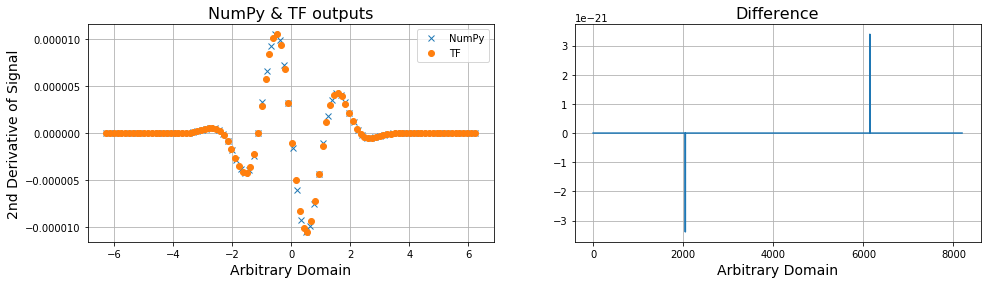

In [0]:
fig1 = plt.figure(figsize=(16,4))

plt1 = fig1.add_subplot(121)
plt1.plot(xax[::96], dense_out_np[::96], 'x', label="NumPy")
plt1.plot(xax[::84], dense_out_tf.numpy()[::84], "o", label="TF")
plt1.set_title("NumPy & TF outputs",fontsize=16)
plt1.set_xlabel("Arbitrary Domain",fontsize=14)
plt1.set_ylabel("2nd Derivative of Signal",fontsize=14)
plt1.legend()
plt1.grid()

plt2 = fig1.add_subplot(122)
plt2.plot(dense_out_np - dense_out_tf.numpy())
plt2.set_title("Difference",fontsize=16)
plt2.set_xlabel("Arbitrary Domain",fontsize=14)
plt2.grid()

## Above, we established our testing procedure. We're going to use NumPy's `np.testing.assert_array_equal()` function. We don't expect it to pass but the maximum difference should be within floating point precision 

## Now let's see how this procedure fares on Matrix - Matrix products before we move on to the Sparse functions.

### First, we'll look at dense x dense products

In [0]:
# Generate another matrix the same size as the dense_matrix
data_matrix = np.random.random(dense_matrix.shape)

In [0]:
# We have already assigned the numpy versions of the dense matrix and the data vector
# We can use these to compute the 2nd derivative directly using np.dot
t0 = time.time()
dense_out_np = np.dot(dense_matrix,data_matrix)
t1 = time.time() - t0

print("NumPy DenseMatrix-DenseMatrix Multiply took " + str(round(t1,3)) + " s")

    
# We have to initialize the TF counterparts of the dense matrix and data vector
dense_matrix_tf = tf.constant(dense_matrix)
data_matrix_tf = tf.constant(data_matrix)

# After doing so, we can compute the product using tf.linalg.matvec
t0 = time.time()
dense_out_tf = tf.linalg.matmul(dense_matrix_tf, data_matrix_tf)
t1 = time.time() - t0

print("TF DenseMatrix-DenseMatrix Multiply took " + str(round(t1,3)) + " s")

NumPy DenseMatrix-DenseMatrix Multiply took 17.711 s
TF DenseMatrix-DenseMatrix Multiply took 19.151 s


In [0]:
out = np.testing.assert_array_equal(dense_out_np,dense_out_tf.numpy())
if out == None:
    print ("Success")


AssertionError: ignored

### They're not quite exactly equal. The difference is effectively down to floating point precision.
### Interesting to note that TF computation is 2x slower. However, this is on a CPU. On a GPU, these numbers could be significantly better.

### Now, let's look at sparse x dense products

In [0]:
### Convert NumPy Sparse Matrix to TF Sparse Matrix
def convert_sparse_matrix_to_sparse_tensor(coo_matrix):
    sparse_matrix_tf = tf.SparseTensor(indices=np.array([coo_matrix.row, coo_matrix.col]).T,
                            values=coo_matrix.data,
                            dense_shape=coo_matrix.shape)    
    
    return sparse_matrix_tf

In [0]:
# We have already assigned the numpy versions of the dense matrix and the data vector
# We can use these to compute the 2nd derivative directly using np.dot
t0 = time.time()
dense_out_np = scipy.sparse.coo_matrix.dot(sparse_matrix,data_matrix)
t1 = time.time() - t0

print("NumPy SparseMatrix-DenseMatrix Multiply took " + str(round(t1,3)) + " s")

# We have to initialize the TF counterparts of the dense matrix and data vector
data_matrix_tf = tf.constant(data_matrix)
sparse_matrix_tf = convert_sparse_matrix_to_sparse_tensor(sparse_matrix)

# After doing so, we can compute the product using tf.linalg.matvec
t0 = time.time()
dense_out_tf = tf.sparse.sparse_dense_matmul(sparse_matrix_tf,data_matrix_tf)
t1 = time.time() - t0

print("TF SparseMatrix-DenseMatrix Multiply took " + str(round(t1,3)) + " s")

NumPy SparseMatrix-DenseMatrix Multiply took 3.095 s
TF SparseMatrix-DenseMatrix Multiply took 0.694 s


In [0]:
out = np.testing.assert_array_equal(dense_out_np,dense_out_tf.numpy())
if out == None:
    print ("Success")


Success


#### The above shows that they're exactly equal, which is very surprising. TF is faster by a factor of 2!

### Now let's reverse the order. This means we need to compute XY where Y is sparse. This function is not implemented in a perfectly transparent way, but it does exist! This is where you have to use some matrix algebra identities.

##### Using the transpose operation, we can get to the solution 
#### $(X Y)^T = Y^T X^T$
#### $XY = ((X Y)^T)^T = (Y^T X^T)^T$
##### So we use the existing methods to get $(X Y)^T$ by using tf.sparse.sparse_dense_matmul, where the two arguments are Y and X, and we use the adjoint_a = True, and adjoint_b = True flags to signify that we'd like the function to use the adjoint of those inputs

##### This effectively leads to a computation of $(Y^T X^T)$. 
##### Finally, computing a transpose of this gives you the desired result, which is the computation of the matrix product XY, where Y is sparse

In [0]:
# Compute the reference result from NumPy
t0 = time.time()
dense_reversed_product_np = np.matmul(data_matrix, dense_matrix)
t1 = time.time() - t0
# print("NumPy DenseMatrix-Vector Multiply took " + str(round(t1,3)) + " s")


# Compute the desired result from TF's sparse multiply routine
t0 = time.time()
sparse_reversed_product_tf = tf.transpose(tf.sparse.sparse_dense_matmul(sparse_matrix_tf,data_matrix_tf,adjoint_a = True, adjoint_b = True))
t1 = time.time() - t0
print("TF SparseMatrix-DenseMatrix Multiply took " + str(round(t1,3)) + " s")


# Compute the desired result from TF's dense multiply routine. This won't scale to production!
t0 = time.time()
dense_reversed_product_tf = tf.linalg.matmul(data_matrix_tf, dense_matrix_tf)
t1 = time.time() - t0
print("TF DenseMatrix-DenseMatrix Multiply took " + str(round(t1,3)) + " s")


TF SparseMatrix-DenseMatrix Multiply took 2.952 s
TF DenseMatrix-DenseMatrix Multiply took 18.911 s


### Dense - Dense Multiply is equivalent between Dense NumPy Multiplies vs Dense TF Multiplies

In [0]:
out = np.testing.assert_array_equal(dense_reversed_product_np,dense_reversed_product_tf.numpy())
if out == None:
    print ("Success")


AssertionError: ignored

### Sparse - Dense Multiply is equivalent to the Dense NumPy Multiply. This is the desired result

In [0]:
out = np.testing.assert_array_equal(dense_reversed_product_np,sparse_reversed_product_tf.numpy())
# out = np.testing.assert_array_almost_equal(dense_reversed_product_np,sparse_reversed_product_tf.numpy())
if out == None:
    print ("Success")
    
print (out)

AssertionError: ignored

# So the answer is, 
### `tf.transpose(tf.sparse.sparse_dense_matmul(Y, X, adjoint_a = True, adjoint_b = True))`

### The work here suggests that one should use SparseTensor math because it's cheaper in time and memory depending on the density and size of the matrix.